### This code is used to test fitting a complex decision boundary 

In [1]:
### start code
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from imblearn import keras
from tensorflow import keras
import scipy.special as special
import pandas as pd
from sklearn.model_selection import train_test_split

devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)



Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


# Define the synthetic data 

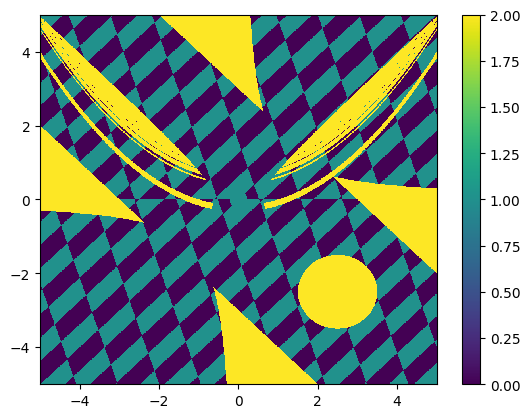

In [12]:
def classify(x,y):
    
    if type(x) == np.float64:
                # class 2
        cond2 = np.logical_or((np.sin((x-y)*5)*np.cos(x*3+y))*y**(3)<0,
                              x**2+y**2<0.05)
        
        # class 3
        cond3 = np.logical_or(np.logical_or(((x**2)-(y**2)>0.4)&(special.gammaln(x**2-y*6)<0  ),
                (  (x-2.5)**2 + (y+2.5)**2 < 1**2  )),
                              (np.abs(x+y)>3)&( (x*y)<1.5  ) )
        
        if cond2: return 1
        elif cond3: return 2
        else: return 0
    else:
    
        res = np.zeros_like(x)
        
        # class 1, where it is zero, do nothing
        
        # class 2
        cond2 = np.logical_or((np.sin((x-y)*5)*np.cos(x*3+y))*y**(3)<0,
                              x**2+y**2<0.05)
        
        # class 3
        cond3 = np.logical_or(np.logical_or(((x**2)-(y**2)>0.4)&(special.gammaln(x**2-y*6)<0  ),
                (  (x-2.5)**2 + (y+2.5)**2 < 1**2  )),
                              (np.abs(x+y)>3)&( (x*y)<1.5  ) )
        
        # print(cond3)
        
        res[cond2] = 1
        res[cond3] = 2
        
        return res
    

x = np.linspace(-5,5,int(1E3))
y = np.linspace(-5,5,int(1E3))

X,Y = np.meshgrid(x,y)




plt.pcolormesh(X,Y,classify(X,Y))
plt.colorbar()
plt.show()

In [3]:
num_classes = 3
x_points = np.linspace(-4.5,4.5,int(5E2))
y_points = np.linspace(-4.5,4.5,int(5E2))

XP, YP = np.meshgrid(x_points,y_points)
Cf = classify(XP,YP)
x_t = XP.ravel()
y_t = YP.ravel()
lab = Cf.ravel()

# labels =[]
# for i,xp in enumerate(x_points):
#     yp = y_points[i]
#     classif = classify(xp,yp)
#     print(f'x={xp}, y={yp}, classif={classif}')
#     labels.append(classif)

print(np.max(lab))
df = pd.DataFrame({'x':x_t,'y':y_t,'class':lab})



2.0


In [144]:
# shuffle the dataframe 
df=df.sample(frac=1).reset_index(drop=True)

features= df[['x','y']].copy()
labels = df['class'].copy()


# labels_one_hot = keras.utils.to_categorical(labels.to_numpy(),num_classes=num_classes)
X_train, X_test, y_train_class, y_test_class = train_test_split(
    features.to_numpy(), labels.to_numpy(), test_size=0.15, random_state=42, shuffle=True)

# add some random errors in the labels
errors_fraction = 6E-2 # 6%
slice_errors = int(errors_fraction*len(y_train_class))
y_train_class[:slice_errors] = np.random.rand(len(y_train_class[:slice_errors]))
case_0 = y_train_class[:slice_errors]<1/3
case_2 = y_train_class[:slice_errors]>2/3
y_train_class[:slice_errors] = 1
y_train_class[:slice_errors][case_0] = 0
y_train_class[:slice_errors][case_2] = 2

y_train = keras.utils.to_categorical(y_train_class,num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test_class,num_classes=num_classes)

In [9]:
### build the NN model
class MyModel(keras.Model):

  def __init__(self, num_classes=3,**kwargs):
    # super().__init__()
    super(MyModel, self).__init__(**kwargs)
    self.bn1 = keras.layers.BatchNormalization()
    self.dense1 = keras.layers.Dense(units=512, activation='relu')
    self.bn2 = keras.layers.BatchNormalization()

    self.dropout1 = keras.layers.Dropout(0.15)
    self.dense2 = keras.layers.Dense(units=256, activation='relu')

    self.bn3 = keras.layers.BatchNormalization()
    self.dropout2 = keras.layers.Dropout(0.15)
    self.dense3 = keras.layers.Dense(units=128, activation='relu')

    self.bn4 = keras.layers.BatchNormalization()
    self.dropout3 = keras.layers.Dropout(0.15)
    self.dense4 = keras.layers.Dense(units=num_classes, activation='softmax')

  def call(self, inputs):
      x = self.bn1(inputs)
      x = self.dense1(x)
      x = self.bn2(x)
      x = self.dropout1(x)

      x = self.dense2(x)
      x = self.bn3(x)
      x = self.dropout2(x)
      x = self.dense3(x)
      x = self.bn4(x)
      x = self.dropout3(x)
      x = self.dense4(x)

      return x

  def get_config(self):
    config = super().get_config()
    config.update({
      'num_classes': self.num_classes,
    })
    return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)


callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=8,
        verbose=1, mode='auto', restore_best_weights=True)

model = MyModel(num_classes=num_classes)

# Display the model's architecture
model.summary()

Model: "my_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [146]:
## compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),
        callbacks=[callback],batch_size=128,epochs=100,)#steps_per_epoch=850)

Epoch 1/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.4911 - loss: 0.8979 - val_accuracy: 0.5989 - val_loss: 0.7050
Epoch 2/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.5951 - loss: 0.7449 - val_accuracy: 0.6233 - val_loss: 0.6488
Epoch 3/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.6264 - loss: 0.7097 - val_accuracy: 0.6644 - val_loss: 0.6089
Epoch 4/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.6624 - loss: 0.6778 - val_accuracy: 0.7014 - val_loss: 0.5787
Epoch 5/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.6865 - loss: 0.6421 - val_accuracy: 0.7211 - val_loss: 0.5360
Epoch 6/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.7077 - loss: 0.6190 - val_accuracy: 0.7510 - val_loss: 0.5107
Epoch 7/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.7335 - loss: 0.5924 - val_accuracy: 0.7841 - val_loss: 0.4623
Epoch 8/100
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 

In [5]:
# # save the model
# import pickle
# model.save('decision_boundary_model.keras')
# with open('history_decision_boundary_model.pkl', 'wb') as file: 
#     # A new file will be created 
#     pickle.dump(history, file) 

/Users/luigiranno/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


AttributeError: 'MyModel' object has no attribute 'num_classes'

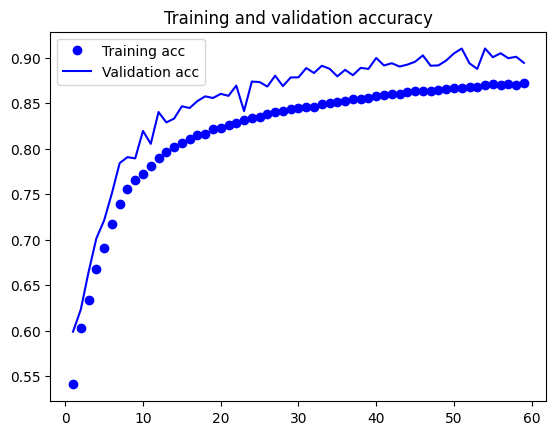

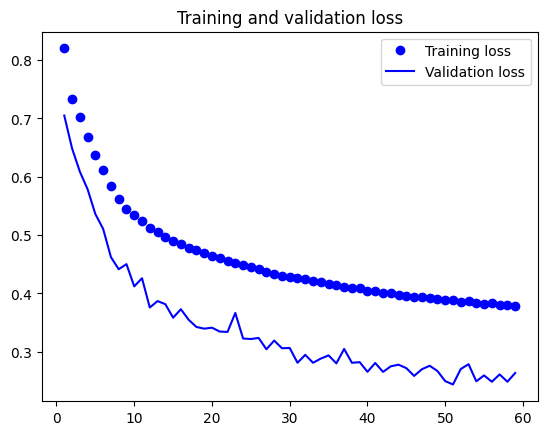

In [154]:
# print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


/Users/luigiranno/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31250/31250 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step


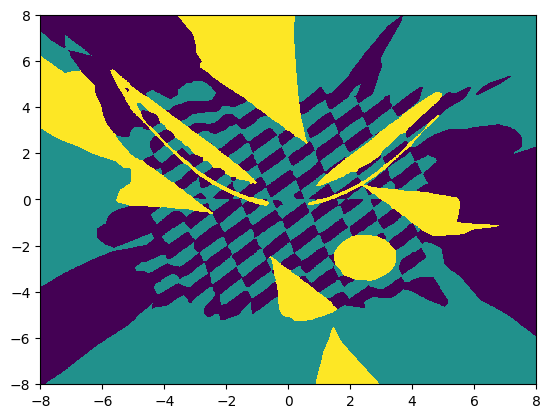

In [13]:
# get the model back from saved state
model = keras.models.load_model('decision_boundary_model.keras',custom_objects={"MyModel": MyModel} )
model.trainable = False # stop training

## plot the decision boundary accoding to the model
Np = 1000

xps = np.linspace(-8,8,Np)#int(1E1))
yps = np.linspace(-8,8,Np)#int(1E1))

Xp, Yp = np.meshgrid(xps,yps)

xpz_input = Xp.ravel()
ypz_input = Yp.ravel()

inputs = np.vstack([xpz_input,ypz_input]).T
outputs = np.argmax(model.predict(inputs),axis=1)

outputs_2d= outputs.reshape(Xp.shape)
plt.pcolormesh(Xp,Yp,outputs_2d)
plt.show()

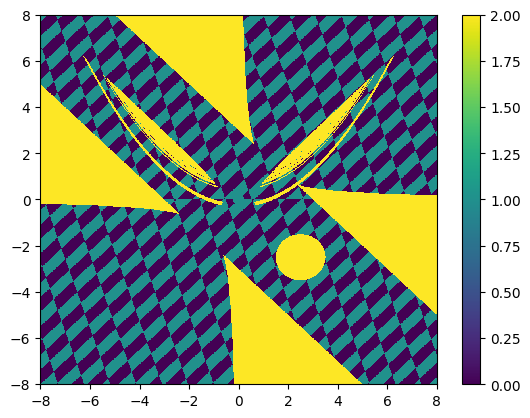

In [14]:
x = np.linspace(-8,8,int(1E3))
y = np.linspace(-8,8,int(1E3))

X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,classify(X,Y))
plt.colorbar()
plt.show()